# Python Project - Varun Gupta and Patrick Chang

## Exercise 1

### Setup

In [2]:
import pandas as pd
import glob
import numpy as np
import operator
import matplotlib.pyplot as plt
import math
import time

### The class definition with functions for each sub-exercise

In [61]:
class BabyNames(object):
    # a) Constructor function
    def __init__(self, path = '.\Data'):
                newlist = []
                columns = ["State", "Sex", "Year", "Name", "Births"]
                for datfile in glob.glob(path + '/*.txt'): #Appending the data from each file to a list
                    statedata = pd.read_csv(datfile, names = columns)
                    newlist.append(statedata)
                self.fulldata = pd.concat(newlist, ignore_index= True) #Creating a pandas data frame from all the file data.
    
    # b) Total number of births
    def Count(self, state = '', year = ''):
        if (state == '') & (year == ''): #Conditions based on whether filters are supplied.
            return self.fulldata['Births'].sum()
        elif state == '': #if only state is not provided
            return self.fulldata[(self.fulldata.Year == int(year))]['Births'].sum()
        elif year == '': #only year is not provided
            return self.fulldata[(self.fulldata.State == state)]['Births'].sum()
        else: #both are provided
            return self.fulldata[(self.fulldata.State == state) & (self.fulldata.Year == int(year))]['Births'].sum()
        
    # c) Top 10 baby names    
    def Top10BabyNames(self, state = '', year = ''):
        #Filtering the data based on supplied conditions (as in count)
        if (state == '') & (year == ''):
            outdf = self.fulldata
        elif state == '':
            outdf = self.fulldata[(self.fulldata.Year == int(year))]
        elif year == '':
            outdf = self.fulldata[(self.fulldata.State == state)]
        else:
            outdf = self.fulldata[(self.fulldata.State == state) & (self.fulldata.Year == int(year))]
        
        #Separating by sex    
        outdfmale = outdf[outdf.Sex == "M"]
        outdffemale = outdf[outdf.Sex == 'F']
        # Creating the required data frames with counts of all births (needed if state or year wasn't supplied)
        outdfmale.groupby(['Name'])['Births'].sum().reset_index()
        outdffemale.groupby(['Name'])['Births'].sum().reset_index()
        #Sorting by births
        outdffemale.sort_values(by = ['Births'], ascending = False, inplace = True)
        outdfmale.sort_values(by = ['Births'], ascending = False, inplace = True)
        outdfmale.index = np.arange(1, len(outdfmale) +1)
        outdffemale.index = np.arange(1, len(outdffemale) +1)
       
        #Creating the required output by sex
        outdffemale.index.name = "Rank"
        outdffemale.rename(columns = {"Name":"Female"}, inplace = True)
        outdffemale = outdffemale["Female"].head(10)
        outdfmale.index.name = "Rank"
        outdfmale.rename(columns = {"Name":"Male"}, inplace = True)
        outdfmale = outdfmale["Male"].head(10)
        #Concatenating for final output
        finaloutpt = pd.concat([outdfmale,outdffemale], axis = 1)
        return finaloutpt
    
    # d) Change of popularity   
    def ChangeOfPopularity(self, fromYear = 2014, toYear = 2015, top = 10):
        addedprop = self.fulldata[self.fulldata["Year"].isin([fromYear, toYear])]
        #Adding a column with the sum of all births in each year.
        addedprop["sumyear"] = self.fulldata.groupby('Year')['Births'].transform('sum')
        #Column with the sum of all births for each name (regardless of sex) in each year.
        addedprop["sumnameyr"] = self.fulldata.groupby(['Year', 'Name'])['Births'].transform('sum')
        #Proportion of babies born with each name
        addedprop["Prop"] = addedprop['sumnameyr']/addedprop['sumyear']
        #Pivoting so each year is a column
        pivoted = addedprop.pivot_table(values = 'Prop', index = 'Name', columns = 'Year')
        #Adding a column for change of popularity (which is the proportion of births)
        pivoted["Change"] = pivoted[toYear] - pivoted[fromYear]
        pivoted["AbsChange"] = abs(pivoted[toYear] - pivoted[fromYear])
        #Printing the required names and their popularities
        print("Names that Increased in Popularity\n")
        print(pivoted[[fromYear, toYear, 'Change']].sort_values(by = ['Change'], ascending = False).head(top))
        print("\n\n\nNames that decreased in Popularity\n")
        print(pivoted[[fromYear, toYear, 'Change']].sort_values(by = ['Change'], ascending = True).head(top))
        #Names whose popularity stayed the same had the smallest absolute change
        print("\n\n\nNames whose popularity stayed the same\n")
        print(pivoted[[fromYear, toYear, 'AbsChange']].sort_values(by = ['AbsChange'], ascending = True).head(top))
    
   # e) Top 5 Most Frequent Names, by state
    def Top5NamesPerYear(self, year=2015, sex = ''):
        #Filtering data for the year of interest
        copydat = self.fulldata[self.fulldata.Year == year]
        #Filtering based on sex if required
        if sex != '':
            copydat = copydat[copydat.Sex == sex]
            if sex == 'M':
                gen = 'Male'
            else:
                gen = 'Female'
        else:
            gen = ''
        #Title for Table
        print("Top 5 " + gen + " Names for Births in " + str(year))
        #Adding the sum of births for each name within each state as a column
        copydat['TotBirths'] = copydat.groupby(['State','Name'])['Births'].transform('sum')
        #Sorting descending based on the number of births
        copydat = copydat.sort_values("TotBirths", ascending = False)
        #Adding the rank for each name in each state based on the number of births in the state
        copydat["Rank"] = copydat.groupby(['State'])['TotBirths'].rank(method = "first", ascending = False)
        #Converting from # to Rank #
        copydat["Rank"] = copydat["Rank"].apply(lambda x: "Rank"+ str(x))
        #Re-grouping the data by state, and selecting only the top 5 ranks
        copydat = copydat.groupby('State').head(5)
        #Printing final results, after pivoting the ranks so that they are columns. swaplevel is so that they appear in alternate order(name, births, name...)
        pivoted = copydat.pivot_table(values = ["Name", "TotBirths"], index = "State", columns = "Rank", aggfunc = lambda x: x).swaplevel(axis = 1).sort_index(axis = 1)
        print(pivoted)
        
    # f) Plot the popularity of a given name over a range of time   
    def NamePopularityPlot(self, name = 'John', yearRange = (2000,2015), state = 'IL', sex = 'M'):
        #Filtering the data so that only datapoints for the given name, year range, state and sex are used
        addedprop = self.fulldata[(self.fulldata.Sex == sex) & (self.fulldata.State == state) & (self.fulldata.Year >= yearRange[0]) & (self.fulldata.Year <= yearRange[1])]
        #Adding a column for the sum of all births in each year
        addedprop["sumyear"] = self.fulldata.groupby('Year')['Births'].transform('sum')
        #Calculating births as a proportion of all births in the given year.
        addedprop["Prop"] = addedprop['Births']/addedprop['sumyear']
        #Filtering for the required name
        addedprop = addedprop[addedprop.Name == name]
        addedprop.fillna(0, inplace = True)
        #Plotting the data
        addedprop = addedprop[["Year","Prop"]]
        addedprop["Prop"] = addedprop["Prop"].apply(lambda x : x * 100000) #Multiplying the proportion by 10^5
        addedprop = addedprop.set_index(["Year"])
        plt.close('all') #Clearing the buffer of plots
        plt.rcParams["figure.figsize"] = [8,6]
        addedprop.plot(color = "Blue")
        plt.ylabel("Proportion * 10^5")
        plt.title("Popularity of Name " + name + " from " + str(yearRange[0]) + " to" + str(yearRange[1]))
        plt.show()
        
    # g) Top n names that have flipped in popularity, gender-wise, over the years
    def NameFlip(self, n = 10):
        #Comparison function - between the count of Male and Female births in a row
        def compFM(x):
            if x.M > x.F:
                return 1
            else:
                return 0
        #Filtering out the name unknown, as it is likely just a dump value for missing name data
        datcopy = self.fulldata[self.fulldata["Name"] != "Unknown"]
        #Pivoting to separate births by sex in two columns.       
        datgender = datcopy.pivot_table(values = 'Births', index = ['Name', 'Year'], columns = 'Sex', aggfunc= 'sum')
        #Converting back to dataframe
        datgender = pd.DataFrame(datgender.to_records())
        #Filling 0 births for missing values for either sex
        datgender.fillna(0, inplace = True)
        datgender = datgender.sort_values(['Name', 'Year'])
        #Comparing which sex had more births for each name in each year.
        datgender["Diff"] = datgender.apply(compFM, axis = 1)
        byname = datgender
        #Adding a lag column for whether male or female was greater (1 if male, 0 if female)
        byname["Lag"] = byname["Diff"].shift(1)
        #If the sex with more births is the same, Changed is 0, otherwise Changed is 1.
        byname["Changed"] = byname.apply(lambda x: abs(x.Diff - x.Lag), axis = 1)
        #In each group, the first row by default has no change. It would have compared to another group so resetting to 0.
        byname.loc[byname.groupby('Name', as_index = False).head(1).index, 'Changed'] = 0
        #Totalling the number of flips.
        byname = byname.groupby('Name')['Changed'].sum()
        byname = byname.reset_index()
        byname = byname.sort_values('Changed', ascending = False).head(n) #Taking the top n names by total number of flips.
        #Table Header
        print("List of top " + str(n) + " names that have flipped between being more popular male or female names")
        print("{:<25}{:<40}".format("Names","Number of Flips"))
        for ix, row in byname.iterrows():
            print("{:<25}{:<40}".format(row["Name"],str(row["Changed"]))) #Table of names and #Flips
        
        datframedict = {}
        nameslist = byname.Name.unique() #Top n names (unique converts to a list, they're already unique)
                
        ctr = 0
        plt.close('all') #Flushing the plot buffer
        plt.rcParams["figure.figsize"] = [12,9] #Increases the size of each plot
        for nam in nameslist:
            ctr = ctr + 1
            plt.figure(ctr) #Create a subplot for each name
            datframedict[nam] = datgender[datgender.Name == nameslist[0]][['Year','M','F']]
            #Converting the births into proportions for each year
            datframedict[nam].M = datframedict[nam].M/(datframedict[nam].M + datframedict[nam].F)
            datframedict[nam].F = 1 - datframedict[nam].M
            
            datframedict[nam].plot(x = 'Year', y = ['M','F'])
            plt.title("Proportion of Male and Female births with the name " + nam + " over time")
            
            plt.legend()
            plt.ylabel('Proportion')
            
        plt.show()
        
    def storyfn(self):
        datgrouped = self.fulldata
        
        datgrouped['SumYear'] = datgrouped.groupby('Year')['Births'].transform('sum')
        datgrouped.reset_index()
        datgrouped = datgrouped[datgrouped["Name"].str.startswith(('Q','U','X','Y','Z'))]
               
        datgrouped.reset_index()
        
        datgrouped["OddProp"] = datgrouped['Births'] * 1000/datgrouped['SumYear']
        datgrouped = datgrouped.groupby('Year')['OddProp'].sum()
        datgrouped.reset_index
        plt.close('all')
        
        datgrouped.plot()
        plt.ylabel("Proportion of total births * 10^3")
        plt.title("Plot showing increasing popularity of names with traditionally odd starting letters (based on judgement - Q,U,X,Y,Z)")
        plt.show()
        
    def bonusstoryfn(self):
        datgrouped= self.fulldata[(self.fulldata['Year'] >= 1999) & (self.fulldata['Year']<2008)]
        datgrouped['SumYear'] = datgrouped.groupby('Year')['Births'].transform('sum')
        datgrouped.reset_index()
        datgrouped = datgrouped[datgrouped["Name"].str.contains('Muhammad|Moohammed|Mahmad|Mehmed|Mahamed|Mohamad|Mohamed|Mohammad|Mohammed|Muhamad|Muhamed|Muhamet|Muhammed|Muhammet|Mahammud')]
        datgrouped["Prop"] = datgrouped['Births'] * 10000/datgrouped['SumYear']
        datgrouped = datgrouped.groupby('Year')['Prop'].sum()
        datgrouped.reset_index
        plt.close('all')
        
        datgrouped.plot()
        plt.ylabel("Proportion of total births * 10^4")
        plt.title("Plot showing sharp decline of births with common spellings of Muhammad after 9/11")
        plt.show()                        
        
    
babobject = BabyNames(".\Data")  #Creating a BabyNames object              

### Function call - count. 
Count takes optional parameters - state and year. If a parameter is missing, all births are counted across all possibilities for the parameter (all states or all years or both)

In [63]:
babobject.Count()

305154531

### Top 10 Baby Names Function Call
For this example, the top 10 baby names, for each sex, in Arizona in 1999 are shown

In [64]:
babobject.Top10BabyNames('AZ', 1999)

C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\varun\Anaconda3\lib\site-packages\pandas\core\frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Male,Female
Rank,,
1,Jacob,Samantha
2,Michael,Alexis
3,Jose,Emily
4,Daniel,Ashley
5,Christopher,Alyssa
6,Joshua,Jessica
7,David,Hannah
8,Anthony,Taylor
9,Matthew,Jennifer


### Change of Popularity - Function Call
For this example, we're showing the top 10 names whose popularity either increased or decreased the most, or stayed almost exactly the same, from 1920 to 2015. Popularity is defined as the proportion of births in that year represented by that name. The change in popularity is taken as the absolute change in this proportion, and not the proportinoal change.

In [67]:
babobject.ChangeOfPopularity(1920,2015,10)

C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Names that Increased in Popularity

Year          1920      2015    Change
Name                                  
Noah      0.000106  0.006296  0.006191
Olivia    0.000233  0.006286  0.006053
Sophia    0.000236  0.005563  0.005328
Mason     0.000045  0.005327  0.005282
Ava       0.000069  0.005230  0.005162
Isabella  0.000092  0.004985  0.004893
Ethan     0.000002  0.004817  0.004815
Jacob     0.000488  0.005095  0.004607
Logan     0.000016  0.004384  0.004367
Elijah    0.000118  0.004353  0.004235



Names that decreased in Popularity

Year          1920      2015    Change
Name                                  
Mary      0.033856  0.000835 -0.033020
John      0.027200  0.003316 -0.023884
Robert    0.023246  0.001953 -0.021293
William   0.023940  0.005078 -0.018862
James     0.022906  0.004732 -0.018173
Dorothy   0.017452  0.000113 -0.017339
Helen     0.016711  0.000230 -0.016481
Margaret  0.013328  0.000667 -0.012661
Ruth      0.012425  0.000340 -0.012084
George    0.012854  0.000972

C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Top 5 Names per Year - Function  Call
For this example, we're ranking the top 5 female names in every state in the year 2015. Sex is an optional parameter, which if left out gives us the top 5 names regardless of sex (taken as a combination, if there are both male and female births).

In [68]:
babobject.Top5NamesPerYear(2015, 'F')

Top 5 Female Names for Births in 2015
Rank    Rank1.0              Rank2.0              Rank3.0            \
           Name TotBirths       Name TotBirths       Name TotBirths   
State                                                                 
AK       Olivia        56       Emma        49     Aurora        46   
AL          Ava       298       Emma       285     Olivia       260   
AR         Emma       214     Olivia       171        Ava       167   
AZ       Sophia       472        Mia       461       Emma       450   
CA       Sophia      2951        Mia      2857       Emma      2715   
CO         Emma       355     Olivia       346        Mia       254   
CT       Sophia       216       Emma       203     Olivia       201   
DC      Genesis        50  Charlotte        47        Ava        47   
DE          Ava        69     Olivia        59     Sophia        57   
FL     Isabella      1378       Emma      1222     Sophia      1174   
GA          Ava       634     Olivia   

### Name Popularity Plot - Function  Call
This method gives us a plot of the popularity of any specified name, in a  specified time range, in a given state, corresponding to a specified sex.
For our example we have plotted the popularity of the name John, as used for males, from 2000 to 2015 in the state of Illinois. Popularity is again defined as the proportion of births, in this case the number of births with that name as a proportion all births in a year, in the specified state corresponding to the specified sex.
We see that the popularity of the name John has been steadily declining.

C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


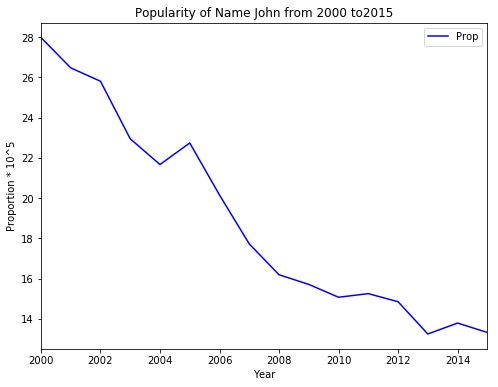

In [85]:
babobject.NamePopularityPlot('John', (2000,2015), 'IL', 'M')

### Name Flip - Function Call
For this exercise, we defined a flip as any time a name changes from being more popular as a male name than a female name, or vice versa, to the opposite, from one year to the next.
We list out the top n names (in this case 10, but can be changed as a parameter), that have 'flipped' in gender popularity over the years, and plot their relative proportions (proportion of births that are male or female) over time.
We dropped the name "Unknown" as it is likely a default for when bad data was received for the name field.
The name which most commonly flips from male to female and back is seen to be "Natividad".

List of top 10 names that have flipped between being more popular male or female names
Names                    Number of Flips                         
Natividad                32.0                                    
Nieves                   23.0                                    
Dell                     23.0                                    
Pilar                    22.0                                    
Lorenza                  20.0                                    
Michal                   20.0                                    
Salome                   19.0                                    
Young                    18.0                                    
Arlis                    16.0                                    
Baby                     16.0                                    


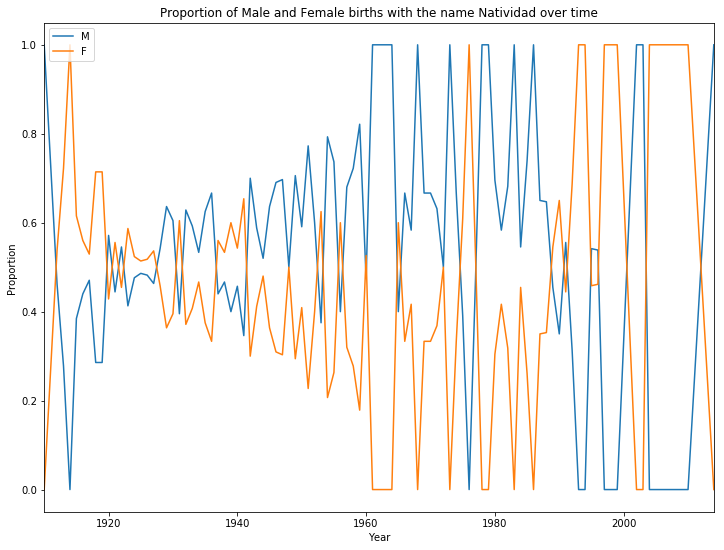

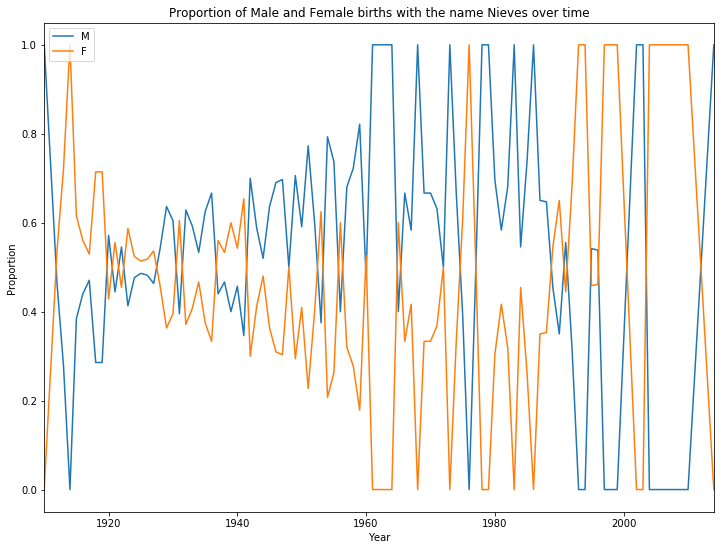

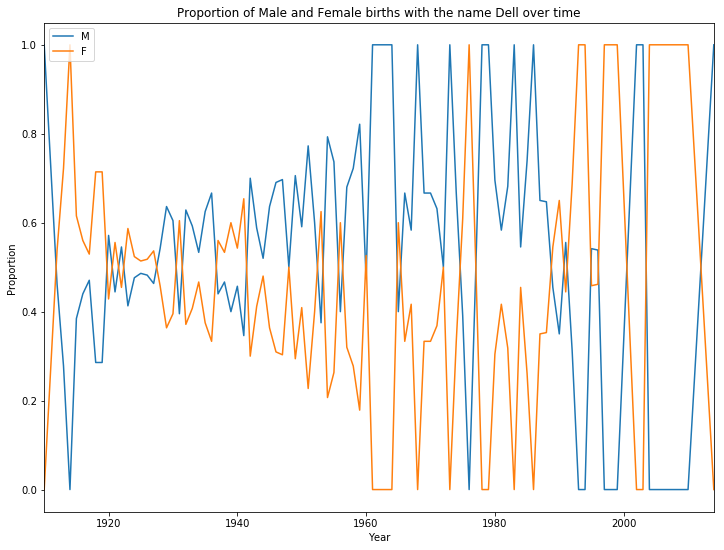

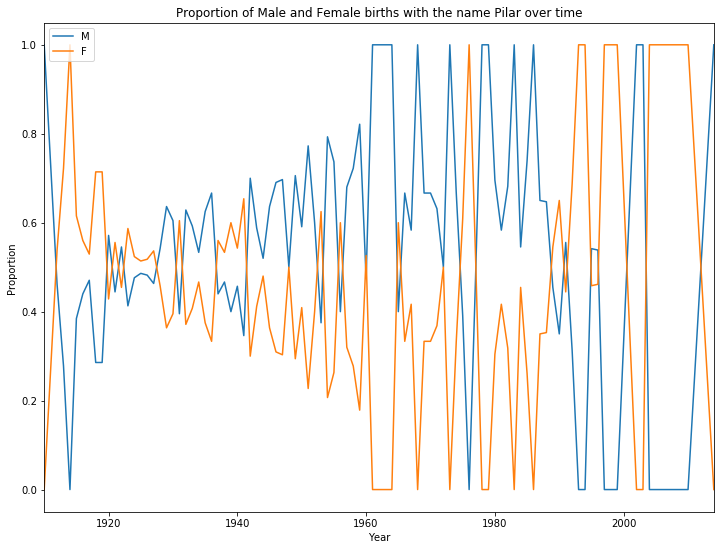

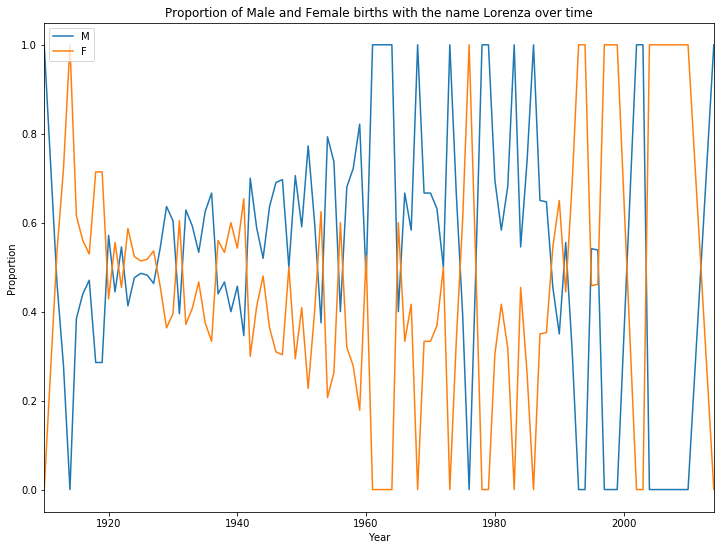

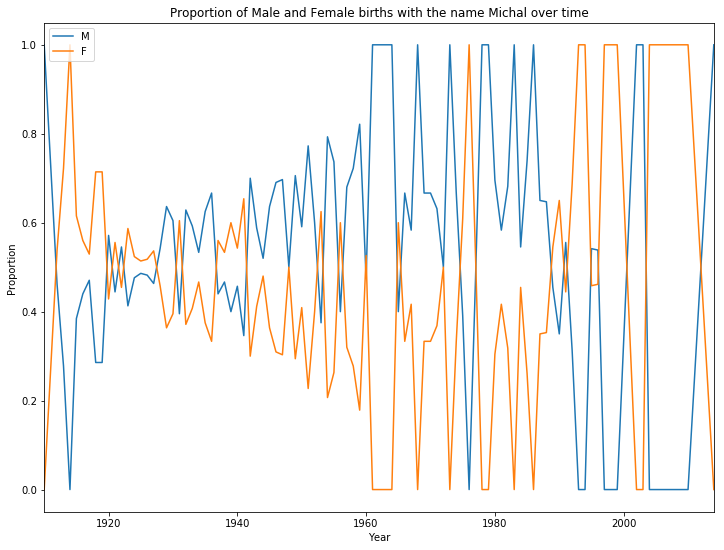

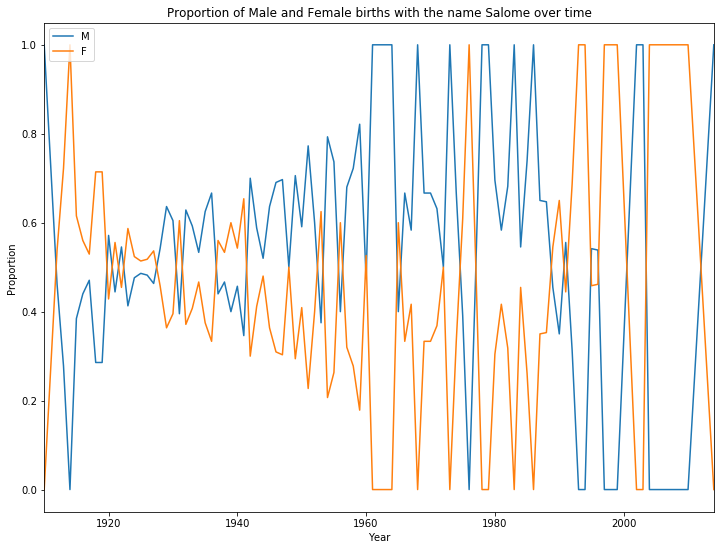

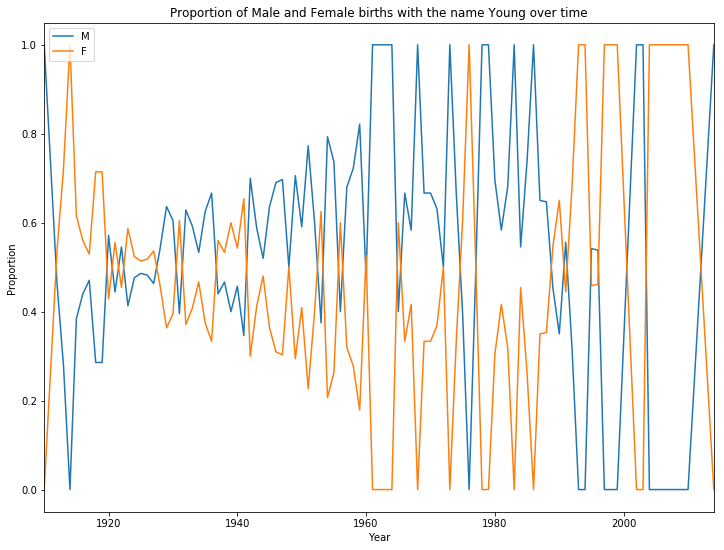

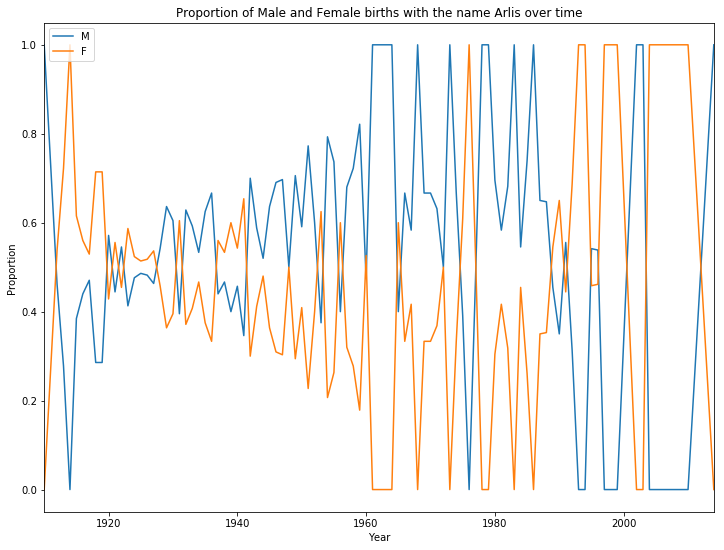

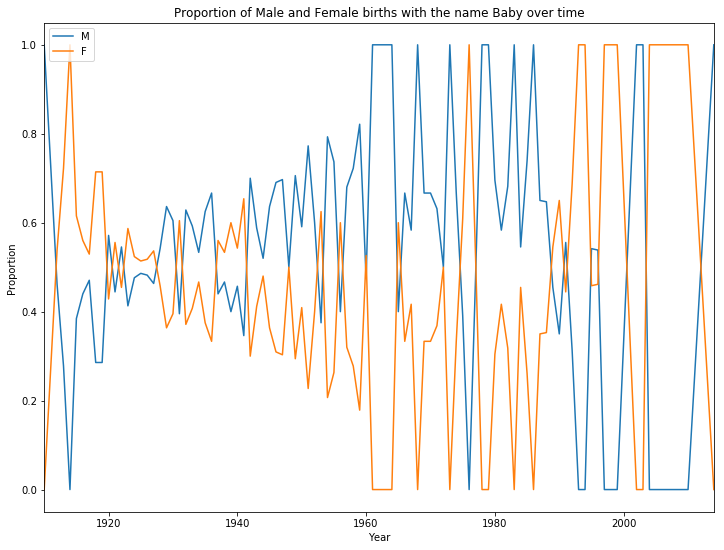

In [76]:
babobject.NameFlip(10)

### Story
For our story, we look at the popularity (across all states) of names that begin with typically non-traditional starting letters, taken in this case to be Q, U, X, Y or Z. Popularity has the usual definition as the number of births starting with any of these letters in a given year, as a proportion of the total number of births in that year.

C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


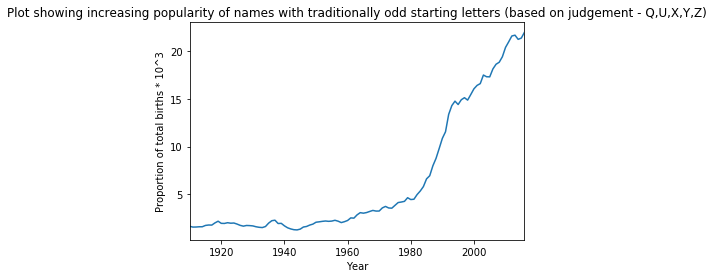

In [49]:
babobject.storyfn()

From the above plot, we can see that the proportion of births with names which begin with traditionally odd letters: Q,U,X,Y or Z, has been steadily and significantly climbing since roughly 1980. This could be due to a number of factors (and likely a combination), including the abandoning of strictly religious names, immigration from countries with different naming traditions, the influence of pop-culture and sci-fi, and even just a growing desire to be different.

### Bonus Story - Just one impact of 9/11
As a bonus story, we look at whether the tragic 9/11 attack had any impact on number of babies given the most common Muslim name - Muhammad, in any of its most common spellings.
Again, we plot the popularity of the name, this time beginning in 1999 and through 2007.

C:\Users\varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


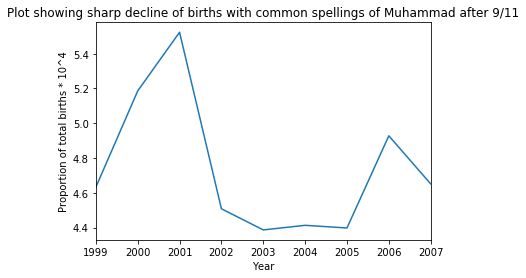

In [62]:
babobject.bonusstoryfn()

Clearly there was a sharp decline in the number of babies who were given these names after the attacks, demonstrating the possible fear in the community of people's attitudes, ostracization, or perhaps even violence, in the aftermath of the 9/11 tragedy.